# Prepare Data.

In [42]:
#Import libraries 
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing
from tpot import TPOTClassifier
from sklearn.preprocessing import Imputer
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn import svm
import sklearn.neural_network
import sklearn.ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from fancyimpute import KNN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV



In [2]:
#Import data for preprocessing
training_data = pd.read_csv('Data/training.csv')
extra_training_data = pd.read_csv('Data/additional_training.csv')
annotator_confidence = pd.read_csv('Data/annotation_confidence.csv')
testing_data = pd.read_csv('Data/testing.csv')
proportions = pd.read_csv('Data/test_proportions.csv')


In [3]:
#Place the complete data in a numpy array
training_array = np.array(training_data)
#Split into input and output data
output = training_array[:,-1]
input_data = training_array[:,1: -1]

Import the extra data

In [5]:
annotator_input = np.array(annotator_confidence)
annotator_input = annotator_input[:,-1]

In [6]:
#Extra data with missing values
extra_training_array = np.array(extra_training_data)

#Split into input and output
extra_output = extra_training_array[:,-1]
extra_input_data = extra_training_array[:,1: -1]


# Spot check algorithims to test performance:

In [7]:
# spot_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 100)
# spot_mlp = sklearn.neural_network.MLPClassifier(solver='sgd',learning_rate_init=0.01,max_iter=5000)
# spot_adaboost = AdaBoostClassifier(n_estimators=100)
# spot_svm = sklearn.svm.SVC()
# spot_kNN = sklearn.neighbors.KNeighborsClassifier()
# spot_RBF = sklearn.gaussian_process.kernels.RBF()



In [8]:
# forest_CV = cross_val_score(spot_forest, input_data, output.ravel(), cv=10)
# print 'Forest ------------'
# print forest_CV
# print forest_CV.mean()
# print forest_CV.var()

# mlp_CV = cross_val_score(spot_mlp, input_data, output.ravel(), cv=10)
# print 'MLP ------------'
# print mlp_CV
# print mlp_CV.mean()
# print mlp_CV.var()

# adaboost_CV = cross_val_score(spot_adaboost, input_data, output.ravel(), cv=10)
# print 'Adaboost ------------'
# print adaboost_CV
# print adaboost_CV.mean()
# print adaboost_CV.var()

# SVM_CV = cross_val_score(spot_svm, input_data, output.ravel(), cv=10)
# print 'SVM ------------'
# print SVM_CV
# print SVM_CV.mean()
# print SVM_CV.var()

# kNN_CV = cross_val_score(spot_kNN, input_data, output.ravel(), cv=10)
# print 'kNN ------------'
# print kNN_CV
# print kNN_CV.mean()
# print kNN_CV.var()



Combine all data together

In [10]:
print extra_input_data.shape
print input_data.shape
input_data = np.concatenate((input_data, extra_input_data), axis=0)
output = np.concatenate((output, extra_output), axis=0)

print input_data.shape
print output.shape
#print output

(3420, 4608)
(380, 4608)
(3800, 4608)
(3800,)


Now the missing values must be dealt with in the extra training data. This will be done simply at first using averages to fill the values. 



In [11]:
#Impute using the most frequent strategy
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0, verbose=0, copy=True)
imp = imp.fit(input_data)
input_data = imp.transform(input_data)

In [12]:
#Imput using K nearest neighbours to fill values
#extra_train_imp = X_filled_knn = KNN(k=3).complete(extra_input_data)
#np.savetxt('imputedKNN.csv', extra_train_imp, fmt='%.2f', delimiter=',', comments='')

Remove ID column from testing data

In [13]:
testing_array = np.array(testing_data)
testing_array = testing_array[:,1:]

Scale the data with 0 mean and unit variance 

In [14]:
scaler = preprocessing.StandardScaler().fit(input_data)
input_data = scaler.transform(input_data)                               
testing_array = scaler.transform(testing_array)

Seperate GIST and CNN data

In [30]:
CNN_input = input_data[:,0:4096]
GIST_input = input_data[:,4096:]
CNN_testing = testing_array[:,0:4096]
print CNN_input.shape
print GIST_input.shape
print CNN_testing.shape

(1922, 4096)
(1922, 0)
(4200, 4096)


# Train CNN and GIST to fit on SVM and RF and evaluate performance 

In [16]:
svm = sklearn.svm.SVC()
forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 100)

forest_CV = cross_val_score(forest, CNN_input, output.ravel(), cv=5)
print 'Forest CNN ------------'
print forest_CV
print forest_CV.mean()


forest_CV = cross_val_score(forest, GIST_input, output.ravel(), cv=5)
print 'Forest GIST------------'
print forest_CV
print forest_CV.mean()


SVM_CV = cross_val_score(svm, CNN_input, output.ravel(), cv=5)
print 'SVM CNN ------------'
print SVM_CV
print SVM_CV.mean()

SVM_CV = cross_val_score(svm, GIST_input, output.ravel(), cv=5)
print 'SVM GIST ------------'
print SVM_CV
print SVM_CV.mean()


Forest CNN ------------
[ 0.76052632  0.78157895  0.76842105  0.725       0.73947368]
0.755
Forest GIST------------
[ 0.64868421  0.66315789  0.63552632  0.63684211  0.64342105]
0.645526315789
SVM CNN ------------
[ 0.76710526  0.76973684  0.76315789  0.725       0.73552632]
0.752105263158
SVM GIST ------------
[ 0.70263158  0.69473684  0.68157895  0.62894737  0.63947368]
0.669473684211


# Annotator confidence data: Removing that which the human annotators are not confident on.

In [17]:
annotator_input
unsure_input_data = np.zeros((1878,4096))
unsure_output = np.zeros((1878,1))

confident_input_data = np.zeros((1922,4096))
confident_output = np.zeros((1922,1))
counter = 0
counter_false = 0

for x in range(0,len(annotator_input)):
    if annotator_input[x] == 1:
        confident_input_data[counter] = CNN_input[x]
        confident_output[counter] = output[x]
        counter += 1
    else:
        unsure_input_data[counter_false]= CNN_input[x]
        unsure_output[counter_false] = output[x]
        counter_false += 1

        
        
print counter
print counter_false


1922
1878


In [18]:
#Take data which is unanimious by annotators 

original_input = input_data
original_output = output

input_data = confident_input_data
output = confident_output

# print output

In [19]:
#Split confident data into training and testing portions
X_train, X_test, y_train, y_test = train_test_split(input_data, output, train_size=0.80, test_size=0.20)

In [20]:
#Test shape 
print input_data.shape
print output.shape

(1922, 4096)
(1922, 1)


train random forest and SVM on condifently annotated data

In [21]:
svm = sklearn.svm.SVC()
forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 100)

forest_CV = cross_val_score(forest, X_train, y_train.ravel(), cv=5)
print 'Forest-------'
print forest_CV
print forest_CV.mean()

SVM_CV= cross_val_score(svm, X_train, y_train.ravel(), cv=5)
print 'SV----------'
print SVM_CV
print SVM_CV.mean()


Forest-------
[ 0.88961039  0.86363636  0.8474026   0.88925081  0.88888889]
0.875757810774
SV----------
[ 0.88636364  0.86688312  0.86688312  0.89576547  0.87581699]
0.878342467181


In [22]:
#Test newly trained calssifiers on unseen data
forest = forest.fit(X_train, y_train.ravel())
svm = svm.fit(X_train, y_train.ravel())

print forest.score(X_test, y_test.ravel())
print svm.score(X_test, y_test.ravel())
print forest.score(unsure_input_data, unsure_output.ravel())
print svm.score(unsure_input_data, unsure_output.ravel())

0.890909090909
0.875324675325
0.622470713525
0.625133120341


In [23]:
print forest.score(X_test, y_test.ravel())
print svm.score(X_test, y_test.ravel())

0.890909090909
0.875324675325


# Perform Recursive feature extraction

Optimal number of features : 1846


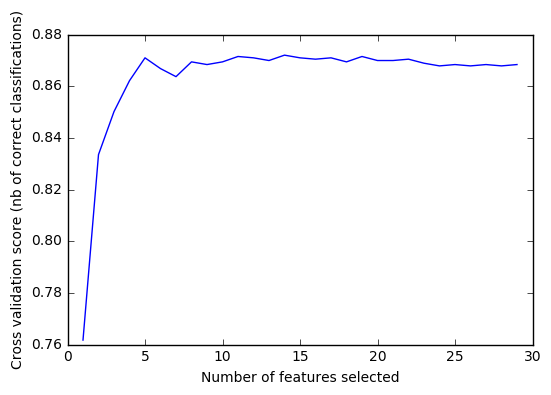

In [24]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=150, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(input_data, output.ravel())

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
svm = LinearSVC()
# create the RFE model for the svm classifier 
# and select attributes
rfe = RFE(svm, 1846)
rfe = rfe.fit(input_data, output.ravel())
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True False ..., False False False]
[1873    1  140 ..., 1019  805 1473]


Transform training and testing data to the new feature space

In [41]:
final_training_input = rfe.transform(input_data)
final_testing_input = rfe.transform(CNN_testing)
print final_training_input.shape
print final_testing_input.shape

(1922, 1846)
(4200, 1846)


# Parameter Optimisation of Random Forest Using Exhaustive GridSearch

In [44]:
forest = sklearn.ensemble.RandomForestClassifier()

In [43]:
#Define list of values that should be explored 
#Will be optimizing for number of trees and leaves in the forest 

tree_range = [10,,20,30,40,50,100,150]
leaf_range = [1,10,25,50]

param_grid = dict(n_estimators = tree_range,  min_samples_leaf = leaf_range)
print(param_grid)


{'n_estimators': [10, 50, 100, 150], 'min_samples_leaf': [1, 10, 25, 50]}


In [46]:
print final_training_input.shape
print output.shape

(1922, 1846)
(1922, 1)


In [50]:
grid = GridSearchCV(forest,param_grid,cv=5,scoring='accuracy')
grid.fit(final_training_input, output.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150], 'min_samples_leaf': [1, 10, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [53]:
print(grid.best_score_)
print(grid.best_params_)

0.884495317378
{'n_estimators': 150, 'min_samples_leaf': 1}


In [54]:
forest = sklearn.ensemble.RandomForestClassifier(min_samples_leaf = 1)
tree_range = [100,150,200,250]
param_grid = dict(n_estimators = tree_range)
print param_grid

{'n_estimators': [100, 150, 200, 250]}


In [55]:
grid = GridSearchCV(forest,param_grid,cv=5,scoring='accuracy')
grid.fit(final_training_input, output.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [56]:
grid.grid_scores_

/Users/Tim/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87877, std: 0.00600, params: {'n_estimators': 100},
 mean: 0.88033, std: 0.01698, params: {'n_estimators': 150},
 mean: 0.87929, std: 0.01663, params: {'n_estimators': 200},
 mean: 0.87721, std: 0.01249, params: {'n_estimators': 250}]

# Final Classifier

In [59]:
forest = sklearn.ensemble.RandomForestClassifier(min_samples_leaf = 1,n_estimators = 150)
forest.fit(final_training_input,output.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [60]:
predicted = forest.predict(final_testing_input)
predicted_prob = forest.predict_proba(final_testing_input)

# Adjust predictions to output labels

In [159]:
predicted_prob = np.array(predicted_prob)
predicted_class = np.array(predicted_class)

In [160]:
#Calculate level of confidence in prediction
confidence = np.amax(predicted_prob, axis=1) 
#Caluclate proportion of values in prediction
ratio = np.sum(predicted_class)/len(predicted_class)

In [161]:
print confidence
print ratio
i = 0
print type(i)
print predicted_class[0]

In [162]:
#Proportions given to us
class1_prop = 0.4286
class2_prop = 0.5714

#order confidence with least confident first
index_array = np.argsort(confidence)
#print confidence
#print index_array

confidence,index_array = (list(t) for t in zip(*sorted(zip(confidence,index_array))))
#print confidence
#print index_array
#list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2))))
#Our ratio should be below class1 prop

i = 0
while ratio > class1_prop:
    predicted_class[index_array[i]] = 0
    i = i+1
    ratio = np.sum(predicted_class)/len(predicted_class)
    print ratio
    
     
print ratio
#Calculate the proportions of the current predictions


In [163]:
print predicted_class
predicted = predicted_class

# Save output to submit online

In [61]:
submit_online = np.arange(1, len(predicted) + 1)
submit_online = np.vstack((submit_online,predicted))
submit_online = submit_online.T
np.savetxt('output.csv', submit_online, fmt='%.2f', delimiter=',', header="ID,prediction", comments='')

# OPTIONAL: Automate machine learing pipeline using TPOT. 

In [26]:
#WARNING: Computationally intensive
tpot = TPOTClassifier(generations= 10, population_size=20, verbosity=2)
tpot.fit(X_train, y_train.ravel())


Optimization Progress:  18%|█▊        | 40/220 [51:17<4:00:20, 80.11s/pipeline]

Generation 1 - Current best internal CV score: 0.876409276572


Optimization Progress:  27%|██▋       | 60/220 [57:13<1:38:22, 36.89s/pipeline]

Generation 2 - Current best internal CV score: 0.880299021198


Optimization Progress:  36%|███▋      | 80/220 [1:08:41<1:20:05, 34.33s/pipeline]

Generation 3 - Current best internal CV score: 0.880299021198


Optimization Progress:  45%|████▌     | 100/220 [1:18:16<58:32, 29.27s/pipeline]

Generation 4 - Current best internal CV score: 0.880299021198


Optimization Progress:  55%|█████▍    | 120/220 [1:34:48<1:12:50, 43.71s/pipeline]

Generation 5 - Current best internal CV score: 0.882911202187


Optimization Progress:  64%|██████▎   | 140/220 [1:49:11<1:04:10, 48.13s/pipeline]

Generation 6 - Current best internal CV score: 0.882911202187


Optimization Progress:  73%|███████▎  | 160/220 [2:07:45<1:04:52, 64.87s/pipeline]

Generation 7 - Current best internal CV score: 0.882911202187


Optimization Progress:  82%|████████▏ | 180/220 [2:29:17<47:50, 71.77s/pipeline]

Generation 8 - Current best internal CV score: 0.882911202187


Optimization Progress:  91%|█████████ | 200/220 [2:33:10<05:38, 16.91s/pipeline]

Generation 9 - Current best internal CV score: 0.882911202187


Generation 10 - Current best internal CV score: 0.883550004742

Best pipeline: LinearSVC(input_matrix, LinearSVC__C=0.0001, LinearSVC__dual=DEFAULT, LinearSVC__loss=hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.01)


In [31]:
tpot_prediction = tpot.predict(CNN_testing)

In [32]:
predicted = tpot_prediction

In [27]:
print tpot.score(X_test, y_test.ravel())
tpot.export('img_classifier_pipeline.py')

0.885714285714
